ToDo: In this notebook.....

# Imports and Functions

## terminal commands for data access

```
autossh -AtX vschuma@ssh1.mdc-berlin.de ssh vschuma@murphy.mdc-berlin.net
# open the ssh screen and/or type
ssh -NR 6667:localhost:22 vfs@79.197.179.128 (current network ID)

# mount
sshfs -p 6667 vschuma@localhost:/data/local/rajewsky/home/vschuma /mnt/murphy_workspace/
or
sshfs vschuma@murphy:/data/local/rajewsky/home/vschuma/ ~/mounts/murphy_workspace/

# if working with the mount is to slow, copy the data to a ramdisk
sudo mount -t tmpfs -o size=6g tmpfs /mnt/ramdisk/

# then copy the file to the ramdisk
mkdir /mnt/ramdisk/data && rsync -av /mnt/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /mnt/ramdisk/data
or
mkdir /dev/shm/data && rsync -av /home/vschuma/mounts/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /dev/shm/data/
# symlink inside the pycharm project to the data dir
(example command)
ln -s /mnt/ramdisk/data data
e.g.: ln -s /mnt/murphy_workspace/NSTT/data/ data
or
ln -s /dev/shm/data/ data
```


In [1]:
from importlib import reload

import anndata
%matplotlib inline

import importlib.util
import sys
# spec = importlib.util.spec_from_file_location("novosparc", "/home/vfs/PycharmProjects/rajewskyLab/novosparc/novosparc/__init__.py")
spec = importlib.util.spec_from_file_location("novosparc", "/home/vschuma/PycharmProjects/novosparc/novosparc/__init__.py")
novosparc = importlib.util.module_from_spec(spec)
sys.modules["novosparc"] = novosparc
spec.loader.exec_module(novosparc)

# import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.viridis()
from matplotlib.gridspec import GridSpec
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import zscore
import sklearn
from sklearn.preprocessing import scale
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import random

FileNotFoundError: [Errno 2] No such file or directory: '/home/vschuma/PycharmProjects/novosparc/novosparc/__init__.py'

## Correlation measurement functions

In [ ]:
def mse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean()

def rmse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.sqrt(np.square(np.subtract(actual,pred)).mean())

def mean_pearson(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = pearsonr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)

def mean_spearman(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = spearmanr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)

def box_swarm_label(plot_df, score_name, single_dfs=None):
    ## plot_df must contain columns "gene", "r score (pearson)", and "method" (being the  reconstruction/cleaning)

    figure(figsize=(11, 12), dpi=80)

    sns.boxplot(x="method", y=score_name, data=plot_df, whis=np.inf)
    sns.swarmplot(x="method", y=score_name, data=plot_df,
                  palette=["crimson","indigo"])

    if single_dfs:
        for counter, single_df in enumerate(single_dfs):

            for x,y, label in zip([counter]*len(plot_df), single_df[score_name], single_df["gene"]):
                plt.text(x = x + 0.1, y = y,
                         s = label,
                         rotation= 45)
    plt.show()

def filter_matrix_for_genes(dataframe, gene_list):
    filtered_df = dataframe[dataframe.gene.isin(gene_list)]
    return filtered_df

def mean_ssim(actual, pred):
    ssim_per_gene = []
    for i in range(actual.shape[1]):
        ssim_score= ssim(actual[:,i],pred[:,i],
                         data_range= pred[:,i].max() -  pred[:,i].min())
        ssim_per_gene.append(ssim_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return ssim_per_gene, np.mean(ssim_per_gene)
# def invest_plot_for_correlations(truth_df, list_of_expression_mtrx, list_of_special_genes, list_of_score_cutoffs)
# ToDo
plt.viridis()

# Data - Read in data and atlas

In [2]:
# test genes
# I couldn't take some  frome the paper (bc they are not in the atlas but handpicked some with strong expression
# pattern

pl_genes_all = ['LGR5', # epithel
            'PAX2',# lumenal
            'SCGB2A2','PAEP', # glandular
            'IGF1', # stroma
            'CFD','CEBPB', 'PDGFRA', # secretory stroma
            'ACTA2', 'OGN' # fibroblasts
             ]
pl_genes = ['LGR5', # epithel
            'PAX2',# lumenal
            'IGF1' # stroma
            ]

In [ ]:

# atlas settings
atlas_dir = 'data/'
target_space_path = os.path.join(atlas_dir, 'endometr_coordinates.txt')
locations = pd.read_csv(target_space_path, sep='\t')

num_locations = 3871 # coming from the spatial data
locations_apriori = locations[:num_locations][['x', 'y']]
# the .values in this case messes up the dataformat. Only when I remove it I get what I need. Why?
locations = np.asarray(locations_apriori)
plt.scatter(locations[:, 0], locations[:, 1], s=3)

In [ ]:
locations

## Reading the highly variable gene atlas

In [ ]:
# atlas_path = os.path.join(atlas_dir, 'uterus_GarciaAlsonso_atlas_dge.csv')
# # atlas = sc.read_csv(atlas_path, delimiter=',') # this always through a Value Error about unmatching column numbers - idea why
#
# chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
# df = pd.concat(chunks)
# atlas = sc.AnnData(df)
# atlas_genes = atlas.var.index.tolist()
# atlas.obsm['spatial'] = locations

### plot atlas genes

In [ ]:
# print(atlas_genes)
# plt.viridis()
# novosparc.pl.embedding(atlas, atlas_genes)

## Reading in spatially informative gene atlas

In [ ]:
atlas_path = os.path.join(atlas_dir, 'uterus_GarciaAlsonso_atlas_spatial_info_dge.csv')
# atlas = sc.read_csv(atlas_path, delimiter=',') # this always through a Value Error about unmatching column numbers - idea why

chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

### plot spatially informative atlas genes

In [ ]:
# plt.viridis()
# novosparc.pl.embedding(atlas, atlas_genes)

## Set truth expression matrix

In [ ]:
expmtrx_truth = atlas.X

# zscore
expmtrx_truth_normed = zscore(expmtrx_truth)
expmtrx_truth_normed.shape

In [ ]:
pl_genes = ['PIGR', 'SLC26A2', 'FAM129A', 'SRD5A3', 'PDLIM7']

# Reconstruction

## Set of plotting genes

## Reading in single cell data

In [ ]:
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'data/'
data_path = os.path.join(data_dir, 'adata_ti_sec_2_sample_normalized_dge.csv')
dataset = sc.read(data_path).T

In [ ]:
gene_names = dataset.var.index.tolist()

In [ ]:
num_cells, num_genes = dataset.shape # 6072 cells x 28614 genes
print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)
# optional: subset cells
# num_cells = 1000
sc.pp.subsample(dataset, n_obs=num_cells)
# dge_rep mode
dge_rep = None # a representation of cells gene expression

## basic reconstruction

In [ ]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

In [ ]:

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)
# dge_rep = None
# tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 1
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))

In [ ]:
dataset_reconst.obsm['spatial'] = locations

In [ ]:
pl_genes = ['PIGR', 'SLC26A2', 'FAM129A', 'SRD5A3', 'SERTM2', 'PDLIM7'] # whole set
# test
plt.viridis()
print("Atlas")
novosparc.pl.embedding(atlas, pl_genes)
print("basic reconstruction")
novosparc.pl.embedding(dataset_reconst, pl_genes)

## reconstruction with GMM cleaning

In [ ]:
# construct tissue object
tissue_postcleaned = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)

# alternative 1: setup both assumptions
tissue_postcleaned.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# tissue_postcleaned.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue_postcleaned.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue_postcleaned.sdge

dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst_postcleaned.obsm['spatial'] = locations

In [ ]:
# check for Na values
print(np.isnan(dataset.X).any())
print(np.isnan(dataset_reconst.X).any())

In [ ]:
# GMM
test_genes = ["SCARA3","IGSF21","PNRC1"]
tissue_postcleaned.cleaning_expression_data(dataset_reconst_postcleaned,tissue_postcleaned.sdge.T,normalization='zscore', selected_genes=test_genes)

In [ ]:

# reconstructed expression of individual genes
sdge_postcleaned = tissue_postcleaned.cleaned_dge
dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge_postcleaned, columns=gene_names))

In [ ]:
dataset_reconst_postcleaned.obsm['spatial'] = locations

In [ ]:
# test
plt.viridis()
print("Atlas")
novosparc.pl.embedding(atlas, pl_genes)
print("basic reconstruction")
novosparc.pl.embedding(dataset_reconst, pl_genes)
print("reconstruction after cleaning")
novosparc.pl.embedding(dataset_reconst_postcleaned, pl_genes)

In [14]:
num_cells, num_genes = dataset.shape # 6072 cells x 28614 genes
print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)
# optional: subset cells
# num_cells = 1000
sc.pp.subsample(dataset, n_obs=num_cells)
# dge_rep mode
dge_rep = None # a representation of cells gene expression

number of cells: 2368
number of genes: 28614


## basic reconstruction

In [15]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

In [16]:

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)
# dge_rep = None
# tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 1
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))

Setting up for reconstruction ... 

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


done ( 21.36 seconds )
Reconstructing spatial information with 77 markers: 2368 cells and 3871 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


<ipython-input-16-13c1bf423e1e>:20: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [17]:
dataset_reconst.obsm['spatial'] = locations

Atlas


<Figure size 432x288 with 0 Axes>

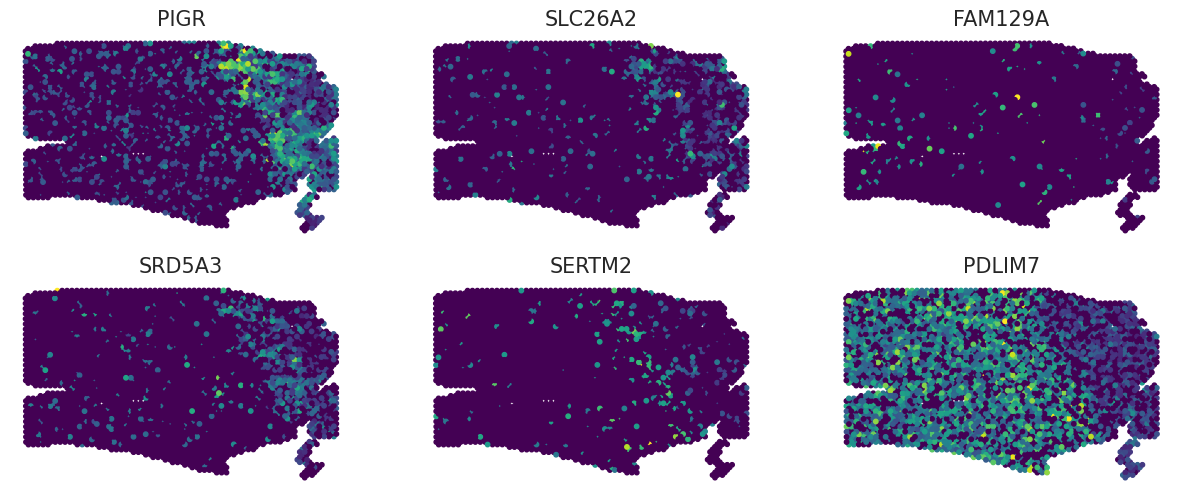

basic reconstruction


<Figure size 432x288 with 0 Axes>

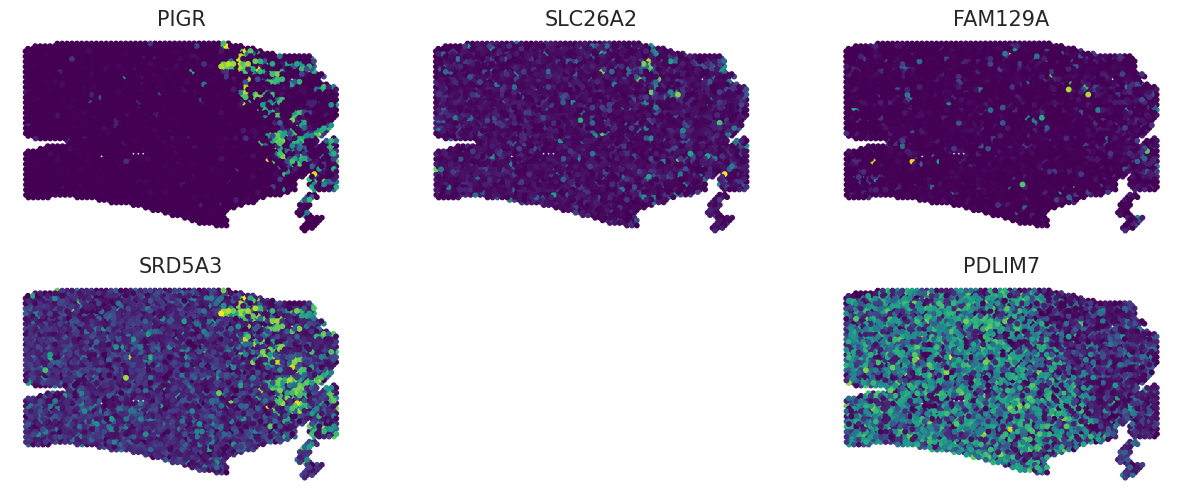

<Figure size 432x288 with 0 Axes>

In [18]:
pl_genes = ['PIGR', 'SLC26A2', 'FAM129A', 'SRD5A3', 'SERTM2', 'PDLIM7'] # whole set
# test
plt.viridis()
print("Atlas")
novosparc.pl.embedding(atlas, pl_genes)
print("basic reconstruction")
novosparc.pl.embedding(dataset_reconst, pl_genes)

## reconstruction with GMM cleaning

In [19]:
# construct tissue object
tissue_postcleaned = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)

# alternative 1: setup both assumptions
tissue_postcleaned.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# tissue_postcleaned.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue_postcleaned.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue_postcleaned.sdge

dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst_postcleaned.obsm['spatial'] = locations

Setting up for reconstruction ... 

/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


done ( 19.96 seconds )
Reconstructing spatial information with 77 markers: 2368 cells and 3871 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


<ipython-input-19-69baac305c93>:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [20]:
# check for Na values
print(np.isnan(dataset.X).any())
print(np.isnan(dataset_reconst.X).any())

False
False


In [ ]:
# GMM
test_genes = ["SCARA3","IGSF21","PNRC1"]
tissue_postcleaned.cleaning_expression_data(dataset_reconst_postcleaned,tissue_postcleaned.sdge.T,normalization='zscore', selected_genes=test_genes)

In [ ]:

# reconstructed expression of individual genes
sdge_postcleaned = tissue_postcleaned.cleaned_dge
dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge_postcleaned, columns=gene_names))

In [ ]:
dataset_reconst_postcleaned.obsm['spatial'] = locations

In [ ]:
# test
plt.viridis()
print("Atlas")
novosparc.pl.embedding(atlas, pl_genes)
print("basic reconstruction")
novosparc.pl.embedding(dataset_reconst, pl_genes)
print("reconstruction after cleaning")
novosparc.pl.embedding(dataset_reconst_postcleaned, pl_genes)